In [1]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [2]:
import pandas as pd

train = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_train.csv")
test = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_test.csv")
cus = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/cus_info.csv")
iem = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/iem_info_20210902.csv")
hist = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_bnc_hist.csv")
submission = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/sample_submission.csv")

In [3]:
train.head(3)

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5


In [4]:
test.head(3)

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0


In [5]:
train["hist_d"] = train["hold_d"]*0.877
train.hist_d = np.trunc(train["hist_d"])

In [6]:
train

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,9.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,70.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,4.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,19.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,284.0
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,0.0
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,0.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,0.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,0.0


In [7]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [8]:
train_data.shape

(681472, 18)

In [9]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [10]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [11]:
train_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0


In [12]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,19.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,284.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,0.0,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,0.0,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,0.0,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


In [13]:
test_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0


In [14]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

## 딥러닝

In [15]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0


In [16]:
train_data.shape

(681472, 18)

In [17]:
train_label.shape

(681472,)

In [18]:
train_label = train_label.values.reshape((-1,1))

In [19]:
train_label.shape

(681472, 1)

In [20]:
# from sklearn.model_selection import train_test_split

# train_x, val_x, train_y, val_y = train_test_split(train_data, train_label, test_size=0.2, random_state=34)

In [21]:
# print(train_x.shape)
# print(train_y.shape)
# print(val_x.shape)
# print(val_y.shape)

In [36]:
def build_model():
    model = keras.Sequential([
        layers.Dense(16,input_shape=[18], activation='relu'),
        layers.Dense(8,input_shape=[16], activation='relu'),
        layers.Dense(4,input_shape=[8], activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

In [37]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                304       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [40]:
EPOCHS = 10
history = model.fit(train_data, train_label, epochs=EPOCHS, validation_split=0.2, verbose=1)
history

Epoch 1/10
17037/17037 [==============================] - 8s 466us/step - loss: 8386.9961 - mae: 14.8374 - val_loss: 240.5386 - val_mae: 9.0959
Epoch 2/10
17037/17037 [==============================] - 8s 459us/step - loss: 7329.6104 - mae: 13.3928 - val_loss: 257.3545 - val_mae: 9.3758
Epoch 3/10
17037/17037 [==============================] - 8s 458us/step - loss: 6841.5396 - mae: 12.5500 - val_loss: 154.3453 - val_mae: 7.3976
Epoch 4/10
17037/17037 [==============================] - 8s 483us/step - loss: 10155.9766 - mae: 12.3751 - val_loss: 103.5199 - val_mae: 6.0855
Epoch 5/10
17037/17037 [==============================] - 8s 472us/step - loss: 65490.8320 - mae: 11.0853 - val_loss: 171.0128 - val_mae: 7.1676
Epoch 6/10
17037/17037 [==============================] - 8s 467us/step - loss: 6970.5771 - mae: 10.7786 - val_loss: 90.6119 - val_mae: 5.8616
Epoch 7/10
17037/17037 [==============================] - 8s 468us/step - loss: 3617.7034 - mae: 10.5392 - val_loss: 190.8423 - val_mae

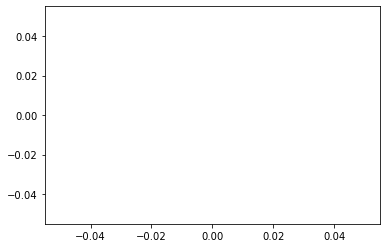

In [41]:
plt.plot(history.history['mae'][50:])

In [42]:
test_data.shape

(70596, 18)

In [43]:
submission["hold_d"] = model.predict(test_data)

In [44]:
submission["hold_d"] = np.round(submission["hold_d"]).astype('int')

In [45]:
submission['hold_d'].unique()

array([ 116,  365,   84,  170,    7,  114,  122,  748,  101,  577,   12,
       1341,  480,    8,  115,   87,  254, 1311,  481,   63,   83,  263,
        514,   13,   89,  918,  137,   30,  147, 1314,  139, 1141, 1363,
        482, 1257, 1316, 1218,  686, 1176, 1318, 1330, 1331, 1322, 1214,
         10,  518,  672,  413,  468,  751,    9,  465,  543,  771,  569,
        521,  504,  581,  768,  756,  599, 1329,   11,   67,   37, 1112,
       1355,  879,  198,   94,  216,   98,   29,  467,   93,   92,   50,
        298,   68,  227,   97,   65,  245,   39,   18,  499,   76,   14,
        551, 1233,   62,  695,   44,   35,  855,  545,  153,  100, 1361,
       1326, 1278, 1335,  453,  981,   58,  174,  789,  237, 1204,  634,
        120,  530,  325,   25,  212, 1055,  106,   46,  459,   72,   88,
         45,  421,   55,  665,   16,   54,  732,   22,  389,  437,  387,
        144,   70,  119,   49,  143,   43,   15,  108,  752,  449,  154,
       1263,  134, 1146,   71,   81,  709, 1289, 12

In [46]:
submission.to_csv("20211010_dnn2.csv", index = False)

## 111.0079